In [1]:
#Import required packages
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import requests
from shapely.geometry import Point
from functools import reduce
import folium
import io
import os
import zipfile
from matplotlib import pyplot as plt
from io import StringIO
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import requests
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import gaussian_process
from sklearn.neighbors import KDTree
from sklearn.model_selection import train_test_split
import skgstat as skg
import gstools as gs
from skgstat import models
from skgstat.util.likelihood import get_likelihood
import scipy
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from scipy.spatial import cKDTree
from scipy.interpolate import NearestNDInterpolator
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import rasterio
from rasterio.transform import from_origin
import random
from rasterio.features import rasterize
import scipy.ndimage
from rasterio.transform import from_origin
from sklearn.neighbors import KNeighborsRegressor
from rasterio.mask import mask
import rasterio.plot

In [2]:
# User defined variables
my_state = 'MN' # State USPS abbreviation
state_name = 'Minnesota'
# IA = 19; ID = 16; IL = 17; MN = 27; MO = 29; MT = 30; OR = 41;  WA = 53; WI = 55
state_fip = 'US%3A27' # Replace last 2 digits with your state's FIP code
my_crs = 5070 # change to recommended projected crs for your state
my_path = 'data/' + my_state + '/' # leave this alone   

In [ ]:
#Helper functions
def get_station_data(state):
    URL_BASE_2 = 'https://www.waterqualitydata.us/data/Station/search?'
    url_request_2 = f"{URL_BASE_2}countrycode=US&statecode={state}"
    response_2 = pd.read_csv(url_request_2)
    return response_2


In [ ]:
# Download state boundaries shapefile
state_boundary_url = 'http://www2.census.gov/geo/tiger/TIGER2012/STATE/tl_2012_us_state.zip'
local_path = my_path
print('Downloading shapefile...')
r = requests.get(state_boundary_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

In [ ]:
# Get USGS monitoring stations from their API
my_stations = get_station_data(state = state_fip)

In [ ]:
#Filter and convert to a Geodataframe
stations = my_stations[['MonitoringLocationIdentifier', 'LatitudeMeasure', 'LongitudeMeasure']].rename(columns = {'MonitoringLocationIdentifier': 'station_id',
                        'LatitudeMeasure' : 'latitude', 'LongitudeMeasure' : 'longitude'})  
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude))

In [ ]:
stations_gdf.to_file(my_path + 'usgs_monitoring_stations.shp')

In [3]:
stations_gdf = gpd.read_file(my_path + 'usgs_monitoring_stations.shp').set_crs(my_crs, allow_override=True)
state_boundary = gpd.read_file(my_path + 'tl_2012_us_state.shp').dropna().set_crs(my_crs, allow_override=True)

state = state_boundary[state_boundary['STUSPS'] == my_state]
my_state_stations = gpd.sjoin(stations_gdf, state, predicate="within")

In [ ]:
def find_nearest(row, other_gdf):
    # Find the index of the nearest geometry
    nearest_idx = other_gdf.distance(row.geometry).idxmin()
    return other_gdf.loc[nearest_idx]

def add_nearest(gdf1, gdf2):
    nearest_neighbors = gdf1.apply(lambda row: find_nearest(row, gdf2), axis=1)
    # Add nearest neighbor information to the first GeoDataFrame
    gdf1['nearest_id'] = nearest_neighbors['station_id']
    gdf1['median'] = nearest_neighbors['median']
    parameter_added = gdf1
    return parameter_added

def get_data(state, characteristic, my_format):
    URL_BASE = 'https://www.waterqualitydata.us/data/Result/search?'
    url_request = f"{URL_BASE}countrycode=US&statecode={state}&characteristicName={characteristic}&mimeType={my_format}"
    response = pd.read_csv(url_request)
    return response

In [ ]:
ca = get_data(state = state_fip, my_format = 'csv', characteristic = 'Calcium')

In [ ]:
pH = get_data(state = state_fip, my_format = 'csv', characteristic = 'pH')

In [ ]:
di_N = get_data(state = state_fip, my_format = 'csv', characteristic = 'Nitrogen')

In [ ]:
do = get_data(state = state_fip, my_format = 'csv', characteristic = 'Oxygen')

In [ ]:
phos = get_data(state = state_fip, my_format = 'csv', characteristic = 'Phosphorus')

In [ ]:
# Note this takes a while....
ca_resultsFile = pd.DataFrame(ca).dropna(subset=['ResultMeasureValue'])
ca_resultsFile.ResultMeasureValue = pd.to_numeric(ca_resultsFile.ResultMeasureValue, errors='coerce')
ca_fixed = ca_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
# Change units for those that are equivalent to mg/L and make ug/L units consistent
ca_clean_1 = ca_fixed.replace({'mg/l' : 'mg/L', 'mg/kg' : 'mg/L', 'mg/l CaCO3': 'mg/L', 'ug/l' : 'ug/L'} )
# convert ug/L to mg/L
ca_clean_1['value'] = ca_clean_1.apply(
    lambda row: row['value'] / 1000 if row['unit'] == 'ug/L' else row['value'],
    axis=1)
#Change unit for converted values to mg/L
ca_clean_2 = ca_clean_1.replace({'ug/L': 'mg/L'})
#Get rid of other records not in mg/L
my_ca = ca_clean_2[ca_clean_2['unit'] == 'mg/L']
#Filter to reasonable values
ca_fixed_2 = my_ca[my_ca['value'] < 300]
ca_fixed_3 = ca_fixed_2[ca_fixed_2['value'] > 0]
#Calculate summary stats by station_id
ca_result = pd.DataFrame(ca_fixed_3.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_ca = pd.merge(my_state_stations, ca_result, on = 'station_id').dropna()

ca_station_list = stations_w_ca['station_id'].tolist()
stations_no_ca = my_state_stations[~my_state_stations['station_id'].isin(ca_station_list)]
ca = add_nearest(stations_no_ca, stations_w_ca)
my_ca_result = pd.concat([ca, stations_w_ca], axis = 0).drop(columns = {"nearest_id","latitude","longitude"})

In [ ]:
my_ca_result.to_file(my_path + 'usgs_ca.shp')

In [ ]:
pH_resultsFile =pd.DataFrame(pH).dropna(subset=['ResultMeasureValue'])
pH_resultsFile.ResultMeasureValue = pd.to_numeric(pH_resultsFile.ResultMeasureValue, errors='coerce')
pH_fixed = pH_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
my_pH = pH_fixed.loc[(pH_fixed['unit'].isna()) | (pH_fixed['unit']== 'std units')]
pH_result = pd.DataFrame(my_pH.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
pH_fixed_2 = pH_result[pH_result['median'] < 14]
pH_fixed_3 = pH_fixed_2[pH_fixed_2['median'] > 4]
stations_w_pH = pd.merge(my_state_stations, pH_fixed_3, on = 'station_id').dropna()

pH_station_list = stations_w_pH['station_id'].tolist()
stations_no_pH = my_state_stations[~my_state_stations['station_id'].isin(pH_station_list)]
pH = add_nearest(stations_no_pH, stations_w_pH)
my_pH_result = pd.concat([pH, stations_w_pH], axis = 0).drop(columns = {"nearest_id", "latitude", "longitude"})


In [ ]:
my_pH_result.to_file(my_path + 'usgs_pH.shp')

In [ ]:
#di_N = get_data(state = state_fip, my_format = 'csv', characteristic = 'Nitrogen')
di_N_resultsFile = pd.DataFrame(di_N).dropna(subset=['ResultMeasureValue'])
di_N_resultsFile.ResultMeasureValue = pd.to_numeric(di_N_resultsFile.ResultMeasureValue, errors='coerce')
di_N_fixed = di_N_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})

di_N_fixed.loc[(di_N_fixed['unit'] == 'ug/L') | 
       (di_N_fixed['unit'] == 'ppb') | (di_N_fixed['unit'] == 'mg/g'), 'value'] /= 1000
di_N_clean_1 = di_N_fixed.replace({'mg/l' : 'mg/L', 'mg/kg' : 'mg/L', 'ppb': 'mg/L', 'ug/L' : 'mg/L'})
di_fixed_2 = di_N_clean_1[di_N_clean_1['unit'] == 'mg/L']
di_fixed_3 = di_fixed_2[di_fixed_2['value']<= 500]
di_fixed_4 = di_fixed_3[di_fixed_3['value'] > 0]
di_N_result = pd.DataFrame(di_fixed_4.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_di_N = pd.merge(my_state_stations, di_N_result, on = 'station_id')#.to_crs(26915)
di_N_station_list = stations_w_di_N['station_id'].tolist()
stations_no_di_N = my_state_stations[~my_state_stations['station_id'].isin(di_N_station_list)]#.to_crs(26915)
di_N = add_nearest(stations_no_di_N, stations_w_di_N)
my_di_N_result = pd.concat([di_N, stations_w_di_N], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})

In [ ]:
my_di_N_result.to_file(my_path + 'usgs_N.shp')

In [ ]:
do_resultsFile = pd.DataFrame(do).dropna(subset=['ResultMeasureValue'])
do_resultsFile.ResultMeasureValue = pd.to_numeric(do_resultsFile.ResultMeasureValue, errors='coerce')
do_fixed = do_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
do_fixed.loc[(do_fixed['unit'] == 'mg/L'), 'value'] *= 12.67
do_clean_1 = do_fixed.replace({'mg/L' : '% saturatn', '% by vol' : '% saturatn'})
do_fixed_2 = do_clean_1[do_clean_1['value']<= 1]
do_fixed_3 = do_fixed_2[do_fixed_2['value']> 0]
do_result = pd.DataFrame(do_fixed_3.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_do = pd.merge(my_state_stations, do_result, on = 'station_id')#.to_crs(26915)
do_station_list = stations_w_do['station_id'].tolist()
stations_no_do = my_state_stations[~my_state_stations['station_id'].isin(do_station_list)]#.to_crs(26915)
do = add_nearest(stations_no_do, stations_w_do)
my_do_result = pd.concat([do, stations_w_do], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})

In [ ]:
my_do_result.to_file(my_path + 'usgs_do.shp')

In [ ]:
phos_resultsFile = pd.DataFrame(phos).dropna(subset=['ResultMeasureValue'])
phos_resultsFile.ResultMeasureValue = pd.to_numeric(phos_resultsFile.ResultMeasureValue, errors='coerce')
phos_fixed = phos_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
phos_fixed.loc[(phos_fixed['unit'] == 'ug/L') | 
       (phos_fixed['unit'] == 'ppb') | (phos_fixed['unit'] == 'mg/g'), 'value'] /= 1000
phos_clean_1 = phos_fixed.replace({'mg/l' : 'mg/L', 'mg/l PO4' : 'mg/L', 'mg/l as P' : 'mg/L', 'mg/kg' : 'mg/L', 'mg/kg as P' : 'mg/L',
                                  'ug/L' : 'mg/L', 'ppb' : 'mg/L', 'mg/g' : 'mg/L'} )
my_phos = phos_clean_1[phos_clean_1['unit'] == 'mg/L']
phos_fixed_2 = my_phos[my_phos['value']<= 1]
phos_result = pd.DataFrame(phos_fixed_2.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_phos = pd.merge(my_state_stations, phos_result, on = 'station_id')#.to_crs(26915)


In [ ]:
phos_station_list = stations_w_phos['station_id'].tolist()
stations_no_phos = my_state_stations[~my_state_stations['station_id'].isin(phos_station_list)]#.to_crs(26915)
phos = add_nearest(stations_no_phos, stations_w_phos)
my_phos_result = pd.concat([phos, stations_w_phos], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})

In [ ]:
my_phos_result.to_file(my_path + 'usgs_phos.shp')

In [ ]:
def interpolate(stations_w_data, filename, bandname="Interpolated_Band", max_grid_size=500):
    # Extract coordinates and values
    stations_w_data['x'] = stations_w_data.geometry.x
    stations_w_data['y'] = stations_w_data.geometry.y
    samples_df = stations_w_data[['x', 'y', 'median']]
    x_point = samples_df['x']
    y_point = samples_df['y']
    coords = np.column_stack((x_point, y_point))
    vals = samples_df['median']
    
    # Scatter plot of original data
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    art = ax.scatter(coords[:, 0], coords[:, 1], s=10, c=vals, cmap='plasma', vmin=0, vmax=vals.max())
    plt.colorbar(art)
    
    # Adaptive grid sizing to prevent memory overflow
    xmin, xmax = x_point.min(), x_point.max()
    ymin, ymax = y_point.min(), y_point.max()
    
    grid_x = min(max_grid_size, int((xmax - xmin) / 500))
    grid_y = min(max_grid_size, int((ymax - ymin) / 500))

    if grid_x * grid_y > 1e6:  # If interpolation grid is too large, skip Kriging
        print("⚠️ Grid too large for Kriging, switching to Nearest Neighbor interpolation.")
        use_kriging = False
    else:
        use_kriging = True
    
    try:
        if use_kriging:
            print("🔹 Attempting Ordinary Kriging interpolation...")
            V = skg.Variogram(coords, vals, model='exponential', maxlag='median', n_lags=30, normalize=False)
            V.plot(show=False)
            print(f'Exponential RMSE: {V.rmse:.2f}')
            print(f'Exponential effective range: {V.describe().get("effective_range"):.1f}')
            
            ok = skg.OrdinaryKriging(V, min_points=1, max_points=8, mode='exact')
            xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]  # Grid definition
            field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
            s2 = ok.sigma.reshape(xx.shape)
            print("✅ Kriging completed successfully.")
        else:
            raise MemoryError  # Manually trigger fallback

    except (MemoryError, ValueError, np.linalg.LinAlgError):
        print("⚠️ Kriging failed due to memory constraints or numerical issues. Switching to Nearest Neighbor interpolation...")

        # Nearest Neighbor Interpolation as fallback
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]  # Ensure the same grid as before
        knn = KNeighborsRegressor(n_neighbors=8, weights='distance', algorithm='kd_tree', n_jobs=-1)
        knn.fit(coords, vals)

        query_points = np.column_stack((xx.ravel(), yy.ravel()))
        nn_values = knn.predict(query_points).reshape(xx.shape)
        field = nn_values.astype(np.float32)
        s2 = np.zeros_like(field)  # No error estimate for Nearest Neighbor interpolation
        print("✅ Nearest Neighbor interpolation completed successfully.")
    
    # Fill NaN values using nearest neighbor interpolation
    def fill_missing_values(field):
        mask = np.isnan(field)  # Identify NaN locations
        if np.all(mask):
            raise ValueError("All values are NaN; interpolation cannot be performed.")
    
        # Compute nearest neighbor indices for NaN positions
        nearest_indices = scipy.ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
    
        # Assign nearest valid values to NaN locations
        field[mask] = field[tuple(nearest_indices[i][mask] for i in range(field.ndim))]
    
        return field

    field = fill_missing_values(field)

    # Export interpolated raster
    nrows, ncols = np.shape(field.T)
    xres = (xmax - xmin) / float(ncols)
    yres = (ymax - ymin) / float(nrows)
    arr = np.abs(field.T).astype(np.float32)

    transform = from_origin(xmin, ymin, xres, -yres)
    export_path = my_path + filename  # Assuming filename is already the full path

    with rasterio.open(export_path, 'w', driver='GTiff',
                       height=arr.shape[0], width=arr.shape[1],
                       count=1, dtype=str(arr.dtype),
                       crs='+proj=utm +zone=15 +ellps=GRS80 +datum=NAD83 +units=m +no_defs',
                       transform=transform) as new_dataset:
        new_dataset.write(arr, 1)
        new_dataset.set_band_description(1, bandname)
    
    print(f"Raster saved: {filename}")


In [ ]:
my_pH_result = gpd.read_file(my_path + 'usgs_pH.shp')
interpolate(my_pH_result, 'pH.tif', 'pH')

In [ ]:
my_ca_result = gpd.read_file(my_path + 'usgs_ca.shp')
interpolate(my_ca_result, 'ca.tif', 'Ca')

In [ ]:
my_di_N_result = gpd.read_file(my_path + 'usgs_N.shp')
interpolate(my_di_N_result, 'di_N.tif', 'Nitrogen')

In [ ]:
my_do_result = gpd.read_file(my_path + 'usgs_do.shp')
interpolate(my_do_result, 'do.tif', 'DO')

In [ ]:
my_phos_result = gpd.read_file(my_path + 'usgs_phos.shp')
interpolate(my_phos_result, 'phos.tif', 'Phos')

In [ ]:
# Start of Biological Variables
# Download waterbody shapefiles by state from NHD 
URL_BASE_NHD = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/State/Shape/'
NHD_url = f"{URL_BASE_NHD}NHD_H_{state_name}_State_Shape.zip"
local_path = my_path
print('Downloading shapefile...')
r = requests.get(NHD_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

In [ ]:
# These are the NAS database species_ids for some of the nastiest AIS
my_nas_ids = [3294,1047,1012,551,730,1107,118,931,1045,3229,4,2937,1130,1134,
2856,237,293,987,1100,92,714,211,538,514,2679,3100,3598,1115,235,239,95,796,910,
217,1259,2938,1120,713,7,214,836,549,162,1688,761,714,1099,229,777,2682,5, 910, 939, 931,
6, 1168, 1110]

In [ ]:
# This function requests and retrieves the AIS records from the USGS NAS database API
def api_call(nas_id, state):
    responses = []
    URL_BASE = 'http://nas.er.usgs.gov/api/v2/'
    url_request = f"{URL_BASE}/occurrence/search?species_ID={nas_id}&state={my_state}"
    response = requests.get(url_request, timeout=None)
    responses.append(response.json())
    return responses

In [ ]:
# This runs the NAS API function and stores the data in a list
api_result = []
for id in my_nas_ids:
    api_result.append(api_call(id, my_state))

In [ ]:
# This formats that list into a dataframe for easier manipulation (filtering)
all_nas_records = []
# Iterate through each data block and append records from 'results' to all_records
for block in api_result:
    for record in block[0]['results']:
        all_nas_records.append(record)

# Create a pandas DataFrame from the list of records
all_nas_df = pd.DataFrame(all_nas_records)
all_nas_data = all_nas_df[["speciesID", "commonName", "group", "state", "decimalLatitude", "decimalLongitude", "year", "status"]]
all_nas_data_fltr = all_nas_data[(all_nas_data['status'] == 'established')].dropna()
nas_gdf = gpd.GeoDataFrame(
    all_nas_data_fltr, geometry=gpd.points_from_xy(all_nas_data_fltr.decimalLongitude, all_nas_data_fltr.decimalLatitude)).set_crs("EPSG:4269")
nas_gdf.to_file(my_path + my_state + "_nas.shp")

In [ ]:
# Load the lake and river shapefiles produced earlier in this script for your state
lakes = gpd.read_file(my_path + "/shape/NHDWaterbody.shp").set_crs("EPSG:4269", allow_override=True)
rivers = gpd.read_file(my_path + "/shape/NHDArea.shp").set_crs("EPSG:4269", allow_override=True)
water = pd.concat([lakes, rivers])
my_water = water[water['areasqkm'] >= 0.05]
# Create 100-meter buffer so we are certain to join points to water and create raster later
my_water['buffer'] = my_water.buffer(.001)
# Drop the original geometry and setting the new geometry
buffered_water = my_water.drop(columns=['geometry']).set_geometry('buffer')
buffered_water = buffered_water.rename_geometry('geometry')
buffered_water.to_file(my_path + my_state + "_buffered_water.shp")

In [4]:
nas_gdf = gpd.read_file(my_path + my_state + "_nas.shp").set_crs("EPSG:4269", allow_override=True)
for col in nas_gdf.select_dtypes(include=['int64']).columns:
    nas_gdf[col] = nas_gdf[col].astype('float64')

In [5]:
buffered_water = gpd.read_file(my_path + my_state + "_buffered_water.shp").set_crs("EPSG:4269", allow_override=True)
NAS_ais_obs_df = gpd.sjoin(nas_gdf, buffered_water, how="inner")

In [6]:
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Fishes', 'Inv_Fish')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Crustaceans-Cladocerans', 'Inv_Crustaceans')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Crustaceans-Crayfish', 'Inv_Crustaceans')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Mollusks-Bivalves', 'Inv_Mollusks')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Mollusks-Gastropods', 'Inv_Mollusks')
NAS_ais_df = NAS_ais_obs_df[['ObjectID', 'commonName', 'group']]
unique_commonnames = NAS_ais_df.groupby(['ObjectID', 'group'])['commonName'].nunique().reset_index()
pivot_df = unique_commonnames.pivot(index='ObjectID', columns='group', values='commonName').reset_index().fillna(0)
lakes_w_invasives = pd.merge(buffered_water, pivot_df, on = 'ObjectID', how = 'left')
# Define the required columns
species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants', 'geometry']

# Add missing columns and fill with 0
for col in species_columns:
    if col not in lakes_w_invasives.columns:
        lakes_w_invasives[col] = 0  # Add missing column with default value 0

# Now safely select the columns and fill NaN values with 0
inv_rich = lakes_w_invasives[species_columns].fillna(0)

In [7]:
for col in inv_rich.select_dtypes(include=['int64']).columns:
    inv_rich[col] = inv_rich[col].astype('float64')

In [17]:
def make_bg_data(geo_df):    
    species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']
    existing_columns = [col for col in species_columns if col in geo_df.columns]  # Only use existing columns
    random_points = []

    for _, row in geo_df.iterrows():
        if not existing_columns or row[existing_columns].sum() == 0:  # Proceed if columns don't exist OR sum is 0
            polygon = row.geometry
            if polygon.is_empty or not polygon.is_valid:
                random_points.append(None)
                continue

            minx, miny, maxx, maxy = polygon.bounds

            while True:
                random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                if polygon.contains(random_point):
                    random_points.append(random_point)
                    break
        else:
            random_points.append(None)  # Keep None for rows that don't match the condition

    return gpd.GeoDataFrame(geometry=random_points, crs=geo_df.crs)

bg_gdf = make_bg_data(inv_rich)  # Generate random points only for selected polygons
bg_gdf.to_file(my_path + my_state +'_bg.shp')

Initial Bounds: xmin=-10932386.676082209, ymin=5093025.025804674, xmax=-9322614.96668413, ymax=6426511.070743449
Updated Raster Dimensions: width=1609, height=1333
Rasterizing Inv_Algae with 23170 geometries
Rasterized Inv_Algae: Min=0.0, Max=0.0
Rasterizing Inv_Crustaceans with 23170 geometries
Rasterized Inv_Crustaceans: Min=0.0, Max=2.0
Rasterizing Inv_Fish with 23170 geometries
Rasterized Inv_Fish: Min=0.0, Max=9.0
Rasterizing Inv_Mollusks with 23170 geometries
Rasterized Inv_Mollusks: Min=0.0, Max=4.0
Rasterizing Inv_Plants with 23170 geometries
Rasterized Inv_Plants: Min=0.0, Max=0.0
Final Sum Band: Min=0.0, Max=14.0
Raster file has been saved as 'data/MN/MN_inv_richness.tif' with band names: ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants', 'Inv_Richness']


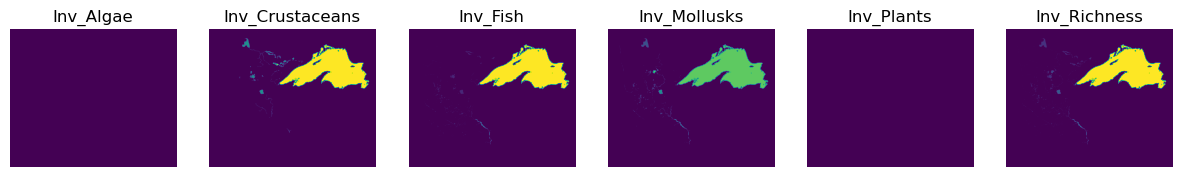

In [8]:
#Convert to a multi-band raster and export as geotiff

inv_rich_gdf = inv_rich.to_crs("EPSG:3857")  # Convert to a projected CRS if necessary

data_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']

# Debug: Ensure GeoDataFrame is not empty
if inv_rich_gdf.empty:
    raise ValueError("Error: The input GeoDataFrame is empty!")

# Set raster parameters
pixel_size = 1000  # 1000 meters per pixel
xmin, ymin, xmax, ymax = inv_rich_gdf.total_bounds  # Get bounding box

# Debug: Print bounding box
print(f"Initial Bounds: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")

# Ensure bounds are valid (expand if necessary)
if xmin == xmax:
    xmin -= pixel_size
    xmax += pixel_size

if ymin == ymax:
    ymin -= pixel_size
    ymax += pixel_size

# Recalculate width and height
width = max(1, int((xmax - xmin) / pixel_size))  # Ensure at least 1 pixel
height = max(1, int((ymax - ymin) / pixel_size))

# Debug: Print updated raster dimensions
print(f"Updated Raster Dimensions: width={width}, height={height}")

# Define the transform for the raster
transform = from_origin(xmin, ymax, pixel_size, pixel_size)

# Number of bands (data columns + 1 for sum)
num_bands = len(data_columns) + 1

# Initialize an empty raster array
raster = np.zeros((num_bands, height, width), dtype=np.float32)

# Rasterize each data column into a separate band
for i, column in enumerate(data_columns):
    shapes = [(geom, value) for geom, value in zip(inv_rich_gdf.geometry, inv_rich_gdf[column]) if geom is not None and not np.isnan(value)]
    
    if not shapes:
        print(f"Skipping {column}: No valid geometries!")
        continue  # Skip empty bands

    print(f"Rasterizing {column} with {len(shapes)} geometries")

    raster_band = rasterize(
        shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,  # Background remains 0
        dtype='float32'  # Preserve decimal values
    )

    print(f"Rasterized {column}: Min={raster_band.min()}, Max={raster_band.max()}")
    raster[i] = raster_band

# Compute the sum band (last band)
raster[-1] = np.sum(raster[:-1], axis=0)
print(f"Final Sum Band: Min={raster[-1].min()}, Max={raster[-1].max()}")

# Save as a multi-band GeoTIFF
output_path = my_path + my_state + '_inv_richness.tif'
with rasterio.open(
    output_path, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=num_bands,
    dtype=raster.dtype,
    crs=inv_rich_gdf.crs,
    transform=transform
) as dst:
    # Write each band
    for band in range(num_bands):
        dst.write(raster[band], band + 1)
    
    # Set band names
    band_names = data_columns + ["Inv_Richness"]
    for band, name in enumerate(band_names, start=1):
        dst.set_band_description(band, name)  # Assign column names to bands

print(f"Raster file has been saved as '{output_path}' with band names: {band_names}")

# --- Plot the first few bands in Jupyter Notebook ---
fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))
titles = data_columns + ["Inv_Richness"]
for i, ax in enumerate(axes):
    ax.imshow(raster[i], cmap='viridis')
    ax.set_title(titles[i])
    ax.axis('off')

plt.show()

In [ ]:
# Download data from USGS native fish presence/absence dataset
URL_BASE = "https://www.sciencebase.gov/catalog/file/get/6086df60d34eadd49d31b04a?f=__disk__ad%2F21%2Ffc%2Fad21fc677379f4e45caa4bd506ca1c587d5f01f7"

response = requests.get(URL_BASE)

if response.status_code == 200:
    # Convert response content to DataFrame
    csv_data = StringIO(response.text)
    fish_df = pd.read_csv(csv_data)

    # Convert DataFrame to GeoDataFrame
    fish_gdf = gpd.GeoDataFrame(
        fish_df, geometry=gpd.points_from_xy(fish_df.longitude, fish_df.latitude)
    ).set_crs(4269)
else:
    print(f"Error: Failed to download data (status code {response.status_code})")


In [ ]:
# Function to clip point geometries by polygon geometries
def clip_points_by_polygon(points_gdf, polygon_gdf):
    # Ensure that both GeoDataFrames are in the same CRS
    if points_gdf.crs != polygon_gdf.crs:
        points_gdf = points_gdf.to_crs(polygon_gdf.crs)

    # Clip the points with the polygon(s)
    clipped_points = gpd.sjoin(points_gdf, polygon_gdf, how='inner')

    # Drop the geometry from polygon_gdf that was added during the join (if needed)
    clipped_points = clipped_points.drop(columns=polygon_gdf.columns.difference(['geometry']))

    return clipped_points

# state_boundary = gpd.read_file(my_path + 'tl_2012_us_state.shp').dropna().to_crs(5070)
# state = state_boundary[state_boundary['STUSPS'] == my_state]
# Clip the points by the polygon
clipped_native_fish = clip_points_by_polygon(fish_gdf, state)
# Save to shapefile


In [ ]:
clipped_native_fish.to_file(my_path + my_state + '_native_fish_gdf.shp')

In [9]:
clipped_native_fish = gpd.read_file(my_path + my_state + '_native_fish_gdf.shp')

In [10]:
def sum_numeric_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Identify columns with six-digit string headers
    sum_columns = [col for col in gdf.columns if col.isdigit() and len(col) == 6]
    
    # Sum across these columns
    gdf["Native_Fish_Richness"] = gdf[sum_columns].sum(axis=1)
    
    # Create a new GeoDataFrame with only the sum and geometry
    return gdf[["Native_Fish_Richness", "geometry"]]
native_fish_gdf = sum_numeric_columns(clipped_native_fish)#.to_crs(4269)

In [11]:
my_water = buffered_water#.to_crs(4269)
def spatial_join_with_nearest(poly_gdf: gpd.GeoDataFrame, point_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Ensure both GeoDataFrames have the same CRS
    if poly_gdf.crs != point_gdf.crs:
        poly_gdf = poly_gdf.to_crs(point_gdf.crs)

    # Perform a nearest spatial join
    joined_gdf = gpd.sjoin_nearest(poly_gdf, point_gdf, how="left", distance_col="distance")

    return joined_gdf

water_w_native_fish = spatial_join_with_nearest(my_water, native_fish_gdf)

In [12]:
for col in water_w_native_fish.select_dtypes(include=['int64']).columns:
    water_w_native_fish[col] = water_w_native_fish[col].astype('float64')

In [13]:
def export_to_raster(joined_gdf: gpd.GeoDataFrame, resolution: int = 1000):
    bounds = joined_gdf.total_bounds  # (minx, miny, maxx, maxy)
    transform = rasterio.transform.from_origin(bounds[0], bounds[3], resolution, resolution)
    out_shape = (
        int(np.ceil((bounds[3] - bounds[1]) / resolution)),  
        int(np.ceil((bounds[2] - bounds[0]) / resolution))
    )
    
    column_name = "Native_Fish_Richness"  # Change this to dynamically select the column if needed
    raster = rasterize(
        [(geom, value) for geom, value in zip(joined_gdf.geometry, joined_gdf[column_name])],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=rasterio.float32
    )
    
    output_filename = f"{my_path}{my_state}_{column_name}_richness.tif"
    
    with rasterio.open(
        output_filename, "w",
        driver="GTiff",
        height=out_shape[0],
        width=out_shape[1],
        count=1,
        dtype=rasterio.float32,
        crs=joined_gdf.crs,
        transform=transform
    ) as dst:
        dst.write(raster, 1)
        dst.set_band_description(1, column_name)  # Set band name
    
    # Plot the raster
    plt.figure(figsize=(10, 6))
    plt.imshow(raster, cmap='viridis', extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
    plt.colorbar(label=f'{column_name} Richness')
    plt.title('Rasterized GeoDataFrame')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

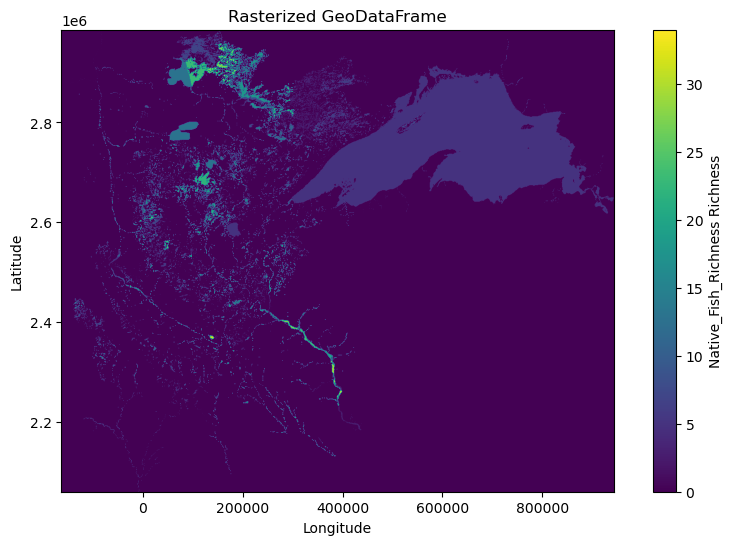

In [14]:
export_to_raster(water_w_native_fish)

In [15]:
def combine_geotiffs(input_files, output_file, state):
    """
    Combines multiple single-band or multi-band GeoTIFFs into a single multi-band image,
    masks it using the provided state GeoDataFrame, and ensures it is upright in the northern hemisphere.
    
    Parameters:
    - input_files (list of str): List of file paths to input GeoTIFFs.
    - output_file (str): Path to the output combined GeoTIFF.
    - state (GeoDataFrame): GeoDataFrame containing the mask geometry.
    """
    
    band_data = []  # Stores all bands
    band_names = []  # Stores band descriptions
    meta = None  # Metadata reference
    
    for file in input_files:
        with rasterio.open(file) as src:
            # Read all bands from the file
            for i in range(1, src.count + 1):
                band_data.append(src.read(i))  # Append band data
                band_name = src.descriptions[i - 1] if src.descriptions[i - 1] else f"Band_{len(band_data)}"
                band_names.append(band_name)  # Store band name
            
            # Set metadata from the first file
            if meta is None:
                meta = src.meta.copy()
    
    # Update metadata for the new multi-band output
    meta.update(count=len(band_data))
    
    # Write combined multi-band GeoTIFF
    with rasterio.open(output_file, 'w', **meta) as dst:
        for i, data in enumerate(band_data):
            dst.write(data, i + 1)  # Write band
            dst.set_band_description(i + 1, band_names[i])  # Preserve band names
    
    # Define a nodata value (use -9999 for integer or np.nan for floating-point rasters)
    nodata_value = -9999 if meta["dtype"].startswith("int") else np.nan
    
    # Apply mask using the state GeoDataFrame
    with rasterio.open(output_file) as src:
        out_image, out_transform = mask(src, state.geometry, crop=True, nodata=nodata_value, all_touched=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": nodata_value
        })
        
        # Apply nodata value manually to the masked array
        out_image = np.where(out_image == 0, nodata_value, out_image)
    
    # Save the masked raster
    with rasterio.open(output_file, "w", **out_meta) as dst:
        for i in range(out_image.shape[0]):
            dst.write(out_image[i], i + 1)
            dst.set_band_description(i + 1, band_names[i])  # Preserve band names
    
    print(f"Successfully created masked and upright {output_file} with {len(band_data)} bands.")
    
    # Print band names for verification
    print("Band Names:")
    for i, name in enumerate(band_names, start=1):
        print(f"Band {i}: {name}")
    
    # Plot the raster for inspection using rasterio's built-in function
    with rasterio.open(output_file) as src:
        fig, ax = plt.subplots(figsize=(10, 6))
        image = src.read(1)
        image_flipped = np.flipud(image)  # Ensure the raster is upright
        rasterio.plot.show(image_flipped, transform=src.transform, ax=ax, cmap='viridis')
        ax.set_title("Masked Raster Inspection")
        plt.show()


Successfully created masked and upright data/MN/MN_raster.tif with 39 bands.
Band Names:
Band 1: Ca
Band 2: pH
Band 3: Nitrogen
Band 4: DO
Band 5: Phos
Band 6: Precip_Winter
Band 7: Precip_Spring
Band 8: Precip_Summer
Band 9: Precip_Fall
Band 10: Flashiness
Band 11: Runoff
Band 12: Drawdown
Band 13: LST_Annual
Band 14: LST_Summer
Band 15: LST_Winter
Band 16: LST_Spring
Band 17: LST_Fall
Band 18: NDVI
Band 19: GPP_Annual
Band 20: GPP_Summer
Band 21: Heat_Insolation
Band 22: Topo_Diversity
Band 23: gHM
Band 24: NDTI
Band 25: NDBI
Band 26: NDCI
Band 27: NDSI
Band 28: Spawn_Ideal
Band 29: Spawn_End
Band 30: Spawn_Start
Band 31: Freeze_Up
Band 32: Ice_Melt
Band 33: Inv_Algae
Band 34: Inv_Crustaceans
Band 35: Inv_Fish
Band 36: Inv_Mollusks
Band 37: Inv_Plants
Band 38: Inv_Richness
Band 39: Native_Fish


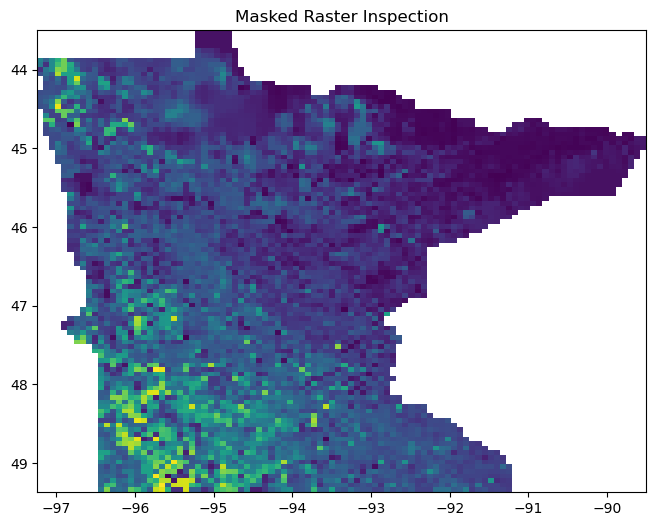

In [16]:
input_files = [my_path + "ca.tif", my_path + "pH.tif", my_path + "di_N.tif", my_path + "do.tif", my_path + "phos.tif", my_path + my_state + "_rsd.tif",
              my_path + my_state + "_inv_richness.tif", my_path + my_state + "_Native_Fish_Richness.tif"]
output_file = my_path + my_state + "_raster.tif"
combine_geotiffs(input_files, output_file, state)
# Print the band names of the output raster
